In [1]:
import pandas as pd
import numpy as np
from fair_logistic_reg import FairLogisticRegression
from custom_log_reg import CustomLogisticRegression
from sklearn.linear_model import LogisticRegression as LogReg
import utils
from autograd import grad

In [2]:
np.random.seed(1337)

In [3]:
class test():
    def func(self, x, y):
        return 2*x*y
    
    def grad_func(self, x, y):
        g = grad(self.func,0)
        return g(x,y)

In [4]:
#compas = utils.load_compas_alt()["train"]
RESPONSE = "two_year_recid"
SENSITIVE = "is_Caucasian"

In [5]:
compas =  utils.load_compas_alt()
compas["train"]["priors_count"] = compas["train"]["priors_count"].apply(lambda x: 1 if x > 0 else 0 )
for col in compas["train"].columns:
    compas["train"][col] = compas["train"][col].apply(lambda x: float(x))
compas["test"]["priors_count"] = compas["test"]["priors_count"].apply(lambda x: 1 if x > 0 else 0 )
for col in compas["test"].columns:
    compas["test"][col] = compas["test"][col].apply(lambda x: float(x))
compas_test =compas["test"]
x_test = compas_test.drop(RESPONSE, axis = 1)
y_test = compas_test[RESPONSE]
z_test = compas_test[SENSITIVE]
x = compas["train"].drop(RESPONSE, axis = 1)
y = compas["train"][RESPONSE]
z = compas["train"][SENSITIVE]

In [6]:
clr = CustomLogisticRegression()
flr = FairLogisticRegression()
sklr = LogReg()

In [7]:
clr.fit(x,y, epochs=100)

100%|██████████| 100/100 [00:27<00:00,  3.61it/s]


In [8]:
flr.fit(x,y,z, epochs=100)

100%|██████████| 100/100 [02:43<00:00,  1.63s/it]


In [9]:
sklr.fit(x,y)

LogisticRegression()

In [10]:
from sklearn.metrics import accuracy_score

In [11]:
from sklearn.metrics import accuracy_score
pred = flr.predict(x_test)
accuracy = accuracy_score(y_test, pred)
print("Fair log reg accuracy: ", accuracy)
pred = clr.predict(x_test)
accuracy = accuracy_score(y_test, pred)
print("Custom log reg accuracy: ", accuracy)
pred = sklr.predict(x_test)
accuracy = accuracy_score(y_test, pred)
print("Sklearn log reg accuracy: ", accuracy)

Fair log reg accuracy:  0.6303387334315169
Custom log reg accuracy:  0.616593028964163
Sklearn log reg accuracy:  0.6323024054982818


In [12]:
def spd(pred, protected_class, positive=True):
        """
        Equation: |P(Y_pred = y | Z = 1) - P(Y_pred = y | Z = 0)|
        Assumes that the positive class is the desired outcome and
            that the protected_class is 0/1 binary"""
        z_1 = [y_hat for y_hat, z in zip(
            pred, np.array(protected_class)) if z == 1]
        z_0 = [y_hat for y_hat, z in zip(
            pred, np.array(protected_class)) if z == 0]

        if not positive:
            z_1 = [0 if z == 1 else 1 for z in z_1]
            z_0 = [0 if z == 1 else 1 for z in z_1]
        """if len(z_1)+len(z_0)!=len(pred):
            print("NOT EQUAL")"""
        return abs(sum(z_1)/len(z_1)-sum(z_0)/len(z_0))
    
def eo_sum(pred, prot, true):
    """
    Equation: |P(Y_pred = y_pred | Y_true = y_true, Z = 1) - P(Y_pred = y_pred | Y_true = y_true, Z = 0)|
    Assumes prot is 0/1 binary"""
    z1_y0 = [y_hat for y_hat, z, y in zip(
        pred, prot, true) if z == 1 and y == 0]
    z0_y0 = [y_hat for y_hat, z, y in zip(
        pred, prot, true) if z == 0 and y == 0]
    z1_y1 = [y_hat for y_hat, z, y in zip(
        pred, prot, true) if z == 1 and y == 1]
    z0_y1 = [y_hat for y_hat, z, y in zip(
        pred, prot, true) if z == 0 and y == 1]
    return abs(sum(z1_y1)/len(z1_y1)-sum(z0_y1)/len(z0_y1)) + abs(sum(z1_y0)/len(z1_y0)-sum(z0_y0)/len(z0_y0))



In [13]:
sum(flr.predict(x_test))

849

In [14]:
pred = flr.predict(x_test)
accuracy = spd(pred, z_test)
print("Fair log reg spd: ", accuracy)
pred = clr.predict(x_test)
accuracy = spd(pred, z_test)
print("Custom log reg spd: ", accuracy)
pred = sklr.predict(x_test)
accuracy = spd(pred, z_test)
print("Sklearn log reg spd: ", accuracy)

Fair log reg spd:  0.20558250484979157
Custom log reg spd:  0.2759115121185317
Sklearn log reg spd:  0.2187445257368763


In [15]:
#eosum test
#flr = FairLogisticRegression(fairness_metric = "eo_sum")
#flr.fit(x,y,z, epochs=50)
pred = flr.predict(x_test)
accuracy = eo_sum(pred, z_test, y_test)
print("Fair log reg eo_sum: ", accuracy)
pred = clr.predict(x_test)
accuracy = eo_sum(pred, z_test, y_test)
print("Custom log reg eo_sum: ", accuracy)
pred = sklr.predict(x_test)
accuracy = eo_sum(pred, z_test, y_test)
print("Sklearn log reg eo_sum: ", accuracy)

Fair log reg eo_sum:  0.37309869686289465
Custom log reg eo_sum:  0.5191107085330853
Sklearn log reg eo_sum:  0.41296485423406676


100%|██████████| 100/100 [02:19<00:00,  1.40s/it]


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


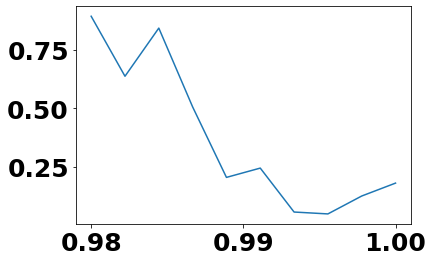

In [16]:
res = []
for l in np.linspace(0.98,1,10):
    flr = FairLogisticRegression(fairness_metric = "eo_sum",  lam = l)
    flr.fit(x,y,z, epochs=100)
    pred = flr.predict(x_test)
    accuracy = eo_sum(pred, z_test, y_test)
    res.append(accuracy)
import matplotlib.pyplot as plt
plt.plot(np.linspace(0.98,1,10), res)

In [18]:
np.linspace(0.95,1,10)

array([0.95      , 0.95555556, 0.96111111, 0.96666667, 0.97222222,
       0.97777778, 0.98333333, 0.98888889, 0.99444444, 1.        ])

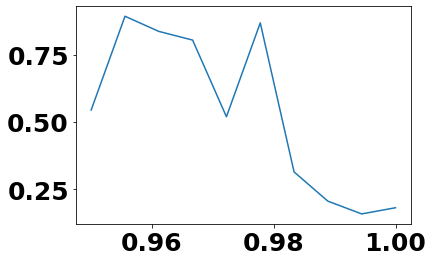

In [17]:
plt.plot(np.linspace(0.95,1,10), res)

In [40]:
res

[0.5191107085330853, 0.5191107085330853]

In [16]:
for ep in [20,50,100,200]:
    flr = FairLogisticRegression(fairness_metric = "eo_sum")
    flr.fit(x,y,z, epochs=ep)
    print("WEIGHTS", flr.weights)
    pred = flr.predict(x_test)
    accuracy = eo_sum(pred, z_test, y_test)
    print("Fair log reg eo_sum: ", accuracy)


100%|██████████| 20/20 [00:26<00:00,  1.33s/it]


WEIGHTS [-25.56736394  25.07310547   2.25439854  23.49591525  36.71145656
 -16.49282962]
Fair log reg eo_sum:  0.815621656343463


100%|██████████| 50/50 [01:05<00:00,  1.32s/it]


WEIGHTS [-43.82519112  50.32740797   2.62826842  45.18814274  46.8202616
 -41.82425269]
Fair log reg eo_sum:  0.8991555431921964


100%|██████████| 100/100 [02:16<00:00,  1.37s/it]


WEIGHTS [-83.57731663  80.26688947   7.01934995  76.21172595  81.84060417
 -74.03327859]
Fair log reg eo_sum:  0.49216766947095514


 14%|█▎        | 27/200 [00:37<03:59,  1.39s/it]


KeyboardInterrupt: 

In [19]:
np.linspace(0,1,10)

array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])

100%|██████████| 100/100 [02:22<00:00,  1.43s/it]


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


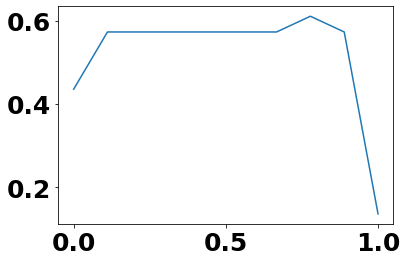

In [23]:
flr.predict(x_test)

[0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
